# Energy from Radial Dependency

In [1]:
from pathlib import Path
import numpy as np
import pandas as pd
pd.options.display.precision = 4
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import seaborn as sbn
%matplotlib inline
plt.rc('text', usetex=True)
plt.rc('font', size=16, family='serif')
plt.rc('figure', figsize=(12, 9))

from kg85 import TabXi

In [2]:
dloc = Path('../data')

Common colors for plots (supposedly color blind frielndly)

In [3]:
clrs = [
    '#000000', '#E69F00', '#56B4E9', '#009E73',
    '#0072B2', '#D55E00', '#CC79A7', '#F0E442'
]
pltt = sbn.color_palette(
    ['#2271B2', '#D55E00', '#359B73', '#E20134', '#A40122', '#000000'])
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

***KG85 reference values and interpolation***

in SI units

In [4]:
txisi = TabXi(mode='SI')

Setting SI units:
  Z:       m/J^(1/3)
  Mx:      -
  pbar:    -
  ta_bar:  s/J^(1/3)
  sigma:   m/s
  td_bar:  s/J^(1/3)
  imp_bar: s/J^(1/3)


in $\mathrm{kg_{{TNT}}}$ equivalent units

In [5]:
txikg = TabXi(mode='KG')

Setting KG units:
  Z:       m/kg^(1/3)
  Mx:      -
  pbar:    -
  ta_bar:  s/kg^(1/3)
  sigma:   m/s
  td_bar:  s/kg^(1/3)
  imp_bar: s/kg^(1/3)


In [6]:
txisi_orig = TabXi(mode='SI')
txisi_orig.impmode = 'orig'  # this changes the whacky interpolation constant

Setting SI units:
  Z:       m/J^(1/3)
  Mx:      -
  pbar:    -
  ta_bar:  s/J^(1/3)
  sigma:   m/s
  td_bar:  s/J^(1/3)
  imp_bar: s/J^(1/3)


In [7]:
txisi.impb_oorb_rolloff_const

6.403726982135217e-08

In [8]:
txisi_orig.impb_oorb_rolloff_const

7.461734048748861e-08

In [9]:
txisi_orig.impb_oorb_rolloff_const / txisi.impb_oorb_rolloff_const - 1

0.16521739130434776

## Helper Funcs

### `format_pow10()`

Format input `num` as LaTeX string 'float times a power of 10'.

In [10]:
def format_pow10(num, prec: int = 2, mult_sign: str = r'\cdot'):
    p10 = int(np.floor(np.log10(num)))
    fac = num / 10 ** p10
    fstr = '{:.' + str(prec) + 'f}'
    fac = fstr.format(fac)
    rets = fac
    if p10 != 0:
        p10 = str(p10)
        rets += r'%s10^{%s}' % (mult_sign, p10)
    return rets

### Load Data

In [11]:
import datarepo
summ = datarepo.get_byu_mics_summ()
byu_mics = datarepo.get_byu_mics()
pos = datarepo.get_pos()
from datarepo import byu_ch, byu_chpmap, xyz, lxyz

available info in main table

In [12]:
summ.columns

Index(['pad', 'ch', 'blast', 'pmax', 'tmax', 'pmin', 'tmin', 'noise', 'ts',
       'tarr', 't1', 't2', 'imp1', 'imp2', 'imp', 'm1', 'm2', 'r', 'x', 'y',
       'z', 'hlabel', 'ppf46', 'alpha', 'depth', 'dbar', 'dredbar', 't', 'c',
       'Ea', 'σEa'],
      dtype='object')

In [13]:
ot = 1 / 3
tt = 2 / 3

### Reference Energies

- `TNT_EQUIV`:\
  $E_\text{TNT}=\ 4.184\,\mathrm{MJ}$, TNT equivalent
- `TNTOT`:\
  $E_\text{TNT}^{1/3}\simeq 161\,\mathrm{J^{1/3}}$
- `EBLAST`\
  $E_\text{b}=0.4265\,\mathrm{MJ}$, ($90\,\mathrm{g}$ Pentex)
- `ETOT`\
  $E_\text{b}^{1/3}\simeq75.9\,\mathrm{J^{1/3}}$

In [14]:
TNT_EQUIV = 4.184e6            
TNTOT = TNT_EQUIV ** ot        
PENTEX_SPEC_EN = 4.85e6        
EBLAST = PENTEX_SPEC_EN * .09  
ETOT = EBLAST ** ot            

TNT weight equivalent of used Pentex charges

In [15]:
WEXP = .09 * PENTEX_SPEC_EN / TNT_EQUIV
WEXPTOT = WEXP ** ot
WEXP

0.10432600382409178

### Radial Fit Functions `linear()`, `inverse()`

In [16]:
def linear(x, a, b):
    return a * x + b

def inverse(x, a):
    return a / x

### Locations of Mics/Channels

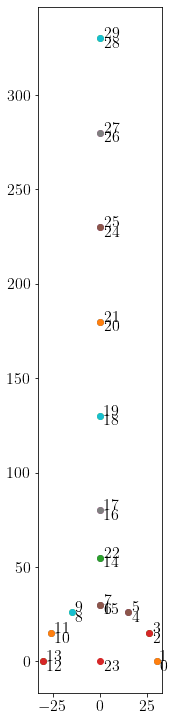

In [17]:
fig, ax = plt.subplots()
ax.set_aspect(1)
fig.set_size_inches(4, 10)
fig.subplotpars.top = .99
fig.subplotpars.bottom=.05

for ch in byu_mics['pad4'].keys():
    el = byu_mics['pad4'][ch]
    x, y, z = el['chX'], el['chY'], el['chZ']
    ax.scatter(x, y)
    xt, yt = (x + 2, y) if z > 1 else (x + 2, y - 5.)
    ax.text(xt, yt, str(ch), transform=ax.transData)
fig.tight_layout()

initialize / reset energy column

In [18]:
summ['Ea'] = np.nan
summ['σEa'] = np.nan

- `lch`: lower channels of radial microphone line
- `hch`: upper channels of radial microphone line

In [19]:
lch = byu_ch['rline']['l']
lch = lch[lch != 14]
hch = byu_ch['rline']['h']

- `sell`: All rows containing a channel of `lch`, which have a valid `pmax` value.
- `selh`: same for `hch`

In [20]:
idx = np.full(len(summ), False)
for ch in lch:
    idx = np.logical_or(idx, summ.ch == ch)
idx[summ.pmax == 0.] = False
sell = summ.loc[idx]

idx = np.full(len(summ), False)
for ch in hch:
    idx = np.logical_or(idx, summ.ch == ch)
idx[summ.pmax == 0.] = False
selh = summ.loc[idx]

In [21]:
selh.head()

pad  ch  blast    pmax    tmax   pmin   tmin   noise      ts    tarr  ...  \
36    1   7      1  10.450  0.8905 -9.982  0.905  0.0854  0.8896  0.8896  ...   
37    1   7      2  11.280  1.3910 -8.668  1.406  0.0854  1.3892  1.3893  ...   
38    1   7      3  13.390  1.8900 -8.755  1.911  0.0854  1.8886  1.8886  ...   
39    1   7      4   4.204  2.3940 -1.623  2.426  0.0854  2.3925  2.3928  ...   
40    1   7      5   5.235  2.8960 -2.148  2.927  0.0854  2.8914  2.8919  ...   

    hlabel    ppf46  alpha  depth    dbar  dredbar    t         c  Ea  σEa  
36       h  12.0568   0.05    0.3  0.0040   0.0040  0.0  341.2904 NaN  NaN  
37       h  12.3990   0.05    0.3  0.0040   0.0040  0.0  341.2904 NaN  NaN  
38       h  11.5531   0.05    0.3  0.0040   0.0040  0.0  341.2904 NaN  NaN  
39       h   3.9219   0.05    0.6  0.0079   0.0046  1.5  341.2904 NaN  NaN  
40       h   4.6980   0.05    0.6  0.0079   0.0045  1.5  341.2904 NaN  NaN  

[5 rows x 31 columns]

Switch to control which energy fit results to write to the summary table

In [22]:
ea_use_pp = False

## Peak pressure

### Reference Values

Atmospheric pressure (Pa)

In [23]:
pa = 9.76e4

KG85 interpolation for scaled peak pressure and scaled impulse falls off at
$\bar r^{-1}$ at large enough distances. `aref` and `airef` are the repective 
proportionality constants

In [24]:
aref = txisi.pb_oorb_rolloff_const
airef = txisi.impb_oorb_rolloff_const
airef_orig = txisi_orig.impb_oorb_rolloff_const

print(f"aref:       {aref:.3e} m J^-1/3")
print(f"airef:      {airef:.3e} m s J^-2/3")
print(f"airef_orig: {airef:.3e} m s J^-2/3")

aref:       5.135e-03 m J^-1/3
airef:      6.404e-08 m s J^-2/3
airef_orig: 6.404e-08 m s J^-2/3


### Radial Dependency Overview

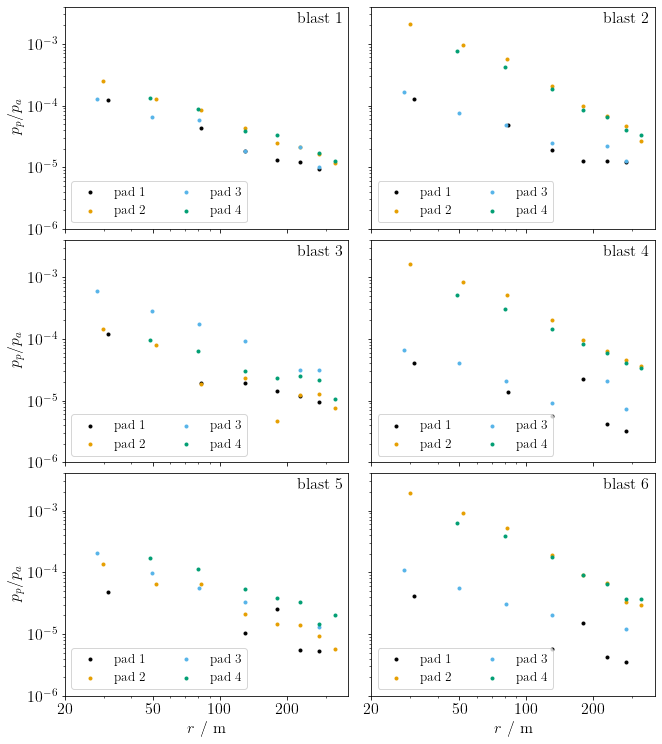

In [25]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True, sharey=True)

for ax, blast in zip(axs.flatten(), [1, 2, 3, 4, 5, 6]):
    ax.set_xscale('log'); ax.set_yscale('log')
    sel1 = selh.loc[selh.blast == blast]
    for pad in [1, 2, 3, 4]:
        sel2 = sel1.loc[sel1['pad'] == pad]
        ax.scatter(sel2.r, sel2.ppf46 / pa, s=9, c=clrs[pad - 1],
                   label='pad %d' % pad)
    ax.legend(loc='lower left', ncol=2, fontsize='small')
    ax.text(.98, .98, 'blast %i' % blast, ha='right', va='top',
            transform=ax.transAxes)
    ax.set_ylim(1e-6, 4e-3)
for ax in axs[-1, :]:
    tcks = [20, 50, 100, 200]
    ax.set_xticks(tcks)
    ax.set_xticklabels([r'$%d$' % tck for tck in tcks])
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
for ax in axs[:, 0]:
    ax.set_ylabel(r'$p_p/p_a$')
ax = axs[0, 0]
xp = np.array([30, 300])
ax.set_xlim(20, 380)
fig.subplots_adjust(
    hspace=.05, wspace=.08, top=.97, left=.08, right=.9, bottom=.1)
fig.set_size_inches(10, 11)

### `rplot()`

Somewhat strange function to plot radial dependency, and energy fit of either
pressure or impulse.

In [26]:
xp = np.array([25., 350])
pars = {
    'col': {'p': 'ppf46', 'i': 'imp1'},
    'b':{
        # pressure: b = aref * Ea ** ot, impulse: b = airef * Ea ** tt * pa
        'p': lambda x: aref * x ** ot,
        'i': lambda x: airef * x ** tt * pa
    },
    'scale': {'p': 1 / pa, 'i': 1.}
}

def rplot(idx1, idx2, mode, ylabel, ret: bool = False):
    fig, ax = plt.subplots(figsize=(10, 7))
    sel = summ.loc[idx1]
    sela = summ.loc[idx2]
    fl = sel.iloc[0]
    col, scale = pars['col'][mode], pars['scale'][mode]
    ul = 'upper mics' if fl['hlabel'] == 'h' else 'lower mics'
    ax.set_title('Pad %d, %s' % (fl['pad'], ul))
    ax.set_xscale('log'); ax.set_yscale('log')
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
    ax.set_ylabel(ylabel)
    xmin, xmax = 20, 380
    ymin, ymax = .5 * sel[col].min() * scale, 1.5 * sel[col].max() * scale
    sel1a = sela.loc[sela.blast == 1]
    ax.text(21, .95 * (ymax - ymin) + ymin, 'ch:', va='top', ha='left')
    for _, row in sel1a.iterrows():
        ax.text(row.r, .95 * (ymax - ymin) + ymin, str(row.ch),
                va='top', ha='center')
    lines, labels = [], []
    for blast in [1, 2, 3, 4, 5, 6]:
        sel1 = sel.loc[sel.blast == blast]
        sel1a = sela.loc[sela.blast == blast]
        le, label = [], f"blast {blast}"
        if len(sel1) > 0:
            el, = ax.plot(sel1.r, sel1[col] * scale, 'o', mfc="none",
                          label=f'blast {blast}', mec=clrs[blast - 1])
            le.append(el)
            remidx = pd.Index([a not in sel1.index for a in sel1a.index])
            sel2a = sel1a.loc[remidx]
            sel2a = sel2a.loc[~np.isnan(sel2a.r)]
            Ea = sel1.Ea.iloc[0]
            if not np.isnan(Ea):
                el, = ax.plot(xp, inverse(xp, pars['b'][mode](Ea)),
                              lw=.75, color=clrs[blast - 1])
                le.append(el)
                label += fr': $E_a/E_b=${Ea / EBLAST:.1e}'
        else:
            sel2a = sel1a.loc[~np.isnan(sel1a.r)]
        if len(sel2a) > 0:
            el, = ax.plot(sel2a.r, sel2a[col] * scale,
                          'x', color=clrs[blast - 1])
            le.append(el)
        lines.append(tuple(le))
        labels.append(label)
    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    ticks = [20, 30, 50, 100, 200, 300]
    ax.set_xticks(ticks)
    ax.set_xticklabels([str(tck) for tck in ticks])
    xmin, xmax = ax.get_xlim()
    ax.add_patch(
        plt.Rectangle(xy=(xmin, .8 * (ymax - ymin) + ymin),
                      width=xmax - xmin, height=.2 * (ymax - ymin) + ymin,
                      fc='#e5e5e5', ec=None, zorder=0))
    lines.append(plt.Line2D([], [], c='none', lw=0))
    labels.append(r'--------')
    lines.append(
        (plt.Line2D([], [], c='none', lw=0, marker='o', mec='k', mfc='none'),))
    labels.append('data used for fit')
    lines.append((plt.Line2D([], [], c='none', lw=0, marker='x', mec='k'),))
    labels.append('not used for fit')
    ax.legend(lines, labels, loc='upper left', bbox_to_anchor=(1.01, 1))
    fig.set_size_inches(11.5, 6)
    fig.subplots_adjust(left=.08, bottom=.1, right=.7, top=.95)
    if ret:
        return fig, ax

### Radial Peak Pressure Dependency

Model

$$
\frac{p_p}{p_a} = \frac{a_\mathrm{ref}}{\bar r}
= \frac{a_\mathrm{ref}}{f_\text{d}\,rE_a^{-1/3}}
\quad,\quad
a_\mathrm{ref} = 5.135\times10^{-3}\,\mathrm{m\,J^{-1/3}}
$$

Measured

$$
\frac{p_p}{p_a} = \frac{b}{r}
\quad,\quad
b = \frac{a_\text{ref}E_a^{1/3}}{f_\text{d}}
$$

$$
\frac{r}{\bar r} = \frac{b}{a_\mathrm{ref}}
\quad\Leftrightarrow\quad
E_a = \Bigl(\frac{f_\text{d} b}{a_\mathrm{ref}}\Bigr)^3
$$

For reference blast $f_\text{d}=1$.
For the experiments, $f_\text{d}$ is calculated from temperature, atmospheric pressure, and speed of sound (see notebooks `mics_c.ipynb`, `kestrel-data.ipynb`, `transmission-factor.ipynb`).

ATTENTION: transmission factors not yet done. Need better temperature values...

### `fit_inverse_pp()`, `fit_inverse_pp_log()`

Get energies from peak pressure fits

#### Uncertainties

For now

- normal least squares ($\sigma_b$ is a direct fit result)

$$
\sigma_{E_a} = 3\,\frac{E_a}{b}\sigma_b
$$

- for the log version

$$Y = \ln p = \ln\frac{b}{r} = \ln b - \ln r = X_0 - X$$
- From fit: $\sigma_{X_0}$.
- $\sigma_Y^2 = \sigma_{X_0}^2 + \sigma_X^2$. For now, assume $\sigma_X=0$...
- $\sigma_b = e^{Y}\sigma_Y$

In [27]:
def fit_inverse_pp(sel):
    res = curve_fit(inverse, sel.r, sel.ppf46 / pa)
    b, σb = res[0][0], np.sqrt(res[1][0, 0])
    Ea = (b / aref) ** 3
    σEa = 3 * Ea * σb / b
    return Ea, σEa

def fit_inverse_pp_log(sel):
    res = curve_fit(lambda x, a: a - x,
                    np.log(sel.r), np.log(sel.ppf46 / pa))
    b, σb = np.exp(res[0][0]), res[1][0, 0]
    σb = b * 2 * np.sinh(σb / 2)
    Ea = (b / aref) ** 3
    σEa = 3 * Ea * σb / b
    return Ea, σEa

### `pplot()`

Plot peak pressures, and $r^{-1}$ curves

In [28]:
def ppplot(idx1, idx2, ret: bool = False):
    return rplot(idx1, idx2, ret=ret, mode='p',
                 ylabel=r'$p_p / p_\mathrm{atm}$')

### Pad 1

#### upper mics

In [29]:
sel1 = selh.loc[selh['pad'] == 1]
idx = pd.Index([])

##### blast 1

In [30]:
EBLAST

436500.0

In [31]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.710e-01 +- 5.5e-02, Ea/Eb: 8.50e-07


##### blast 2

In [32]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.188e-01 +- 6.1e-02, Ea/Eb: 9.59e-07


##### blast 3

In [33]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.drop(index=92)  # drop the 82 m station for fit
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.637e-01 +- 2.4e-03, Ea/Eb: 3.75e-07


**Not sure what to do about blasts 4 and 5**

##### blast 6

In [34]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.drop(index=95)  # drop the 82 m station for fit
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.274e-02 +- 1.9e-03, Ea/Eb: 2.92e-08


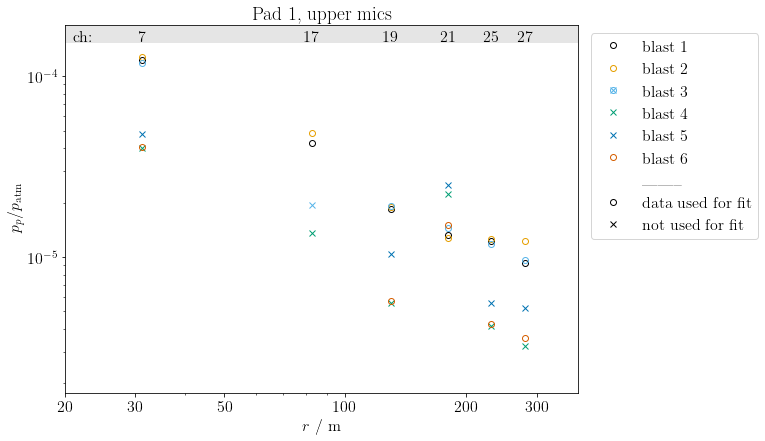

In [35]:
ppplot(idx, sel1.index)

#### lower mics

In [36]:
sel1 = sell.loc[sell['pad'] == 1]
idx = pd.Index([])

##### blast 1

In [37]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.262e-01 +- 9.2e-02, Ea/Eb: 5.18e-07


##### blast 2

In [38]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.562e-01 +- 9.6e-02, Ea/Eb: 5.87e-07


##### blast 3

In [39]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.024e-01 +- 5.7e-03, Ea/Eb: 4.64e-07


##### blast 4

In [40]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.148e-02 +- 3.3e-04, Ea/Eb: 2.63e-08


##### blast 5

In [41]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.707e-02 +- 4.0e-04, Ea/Eb: 3.91e-08


##### blast 6

In [42]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 8.449e-03 +- 2.3e-04, Ea/Eb: 1.94e-08


posx and posy should be finite values
posx and posy should be finite values


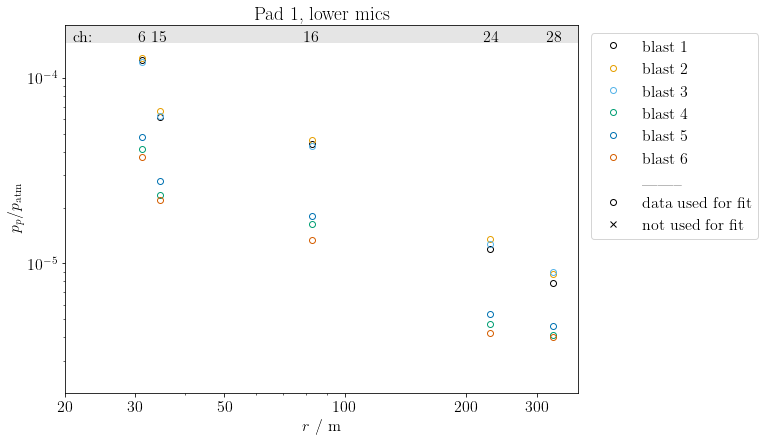

In [43]:
ppplot(idx, sel1.index)

### Pad 2

#### upper mics

In [44]:
sel1 = selh.loc[selh['pad'] == 2]
idx = pd.Index([])

##### blast 1

In [45]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.query('r < 150 & ~r.isnull()', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.200e+00 +- 2.7e-02, Ea/Eb: 5.04e-06


##### blast 2

In [46]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.086e+03 +- 2.8e+01, Ea/Eb: 2.49e-03


##### blast 3

In [47]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.query('~r.isnull() & ch != 21 & ch != 17 & ch != 29',
                  engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.265e-01 +- 6.8e-03, Ea/Eb: 7.48e-07


##### blast 4

In [48]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 6.593e+02 +- 4.2e+00, Ea/Eb: 1.51e-03


##### blast 5

In [49]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.173e-01 +- 8.2e-03, Ea/Eb: 4.98e-07


##### blast 6

In [50]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 8.288e+02 +- 1.7e+01, Ea/Eb: 1.90e-03


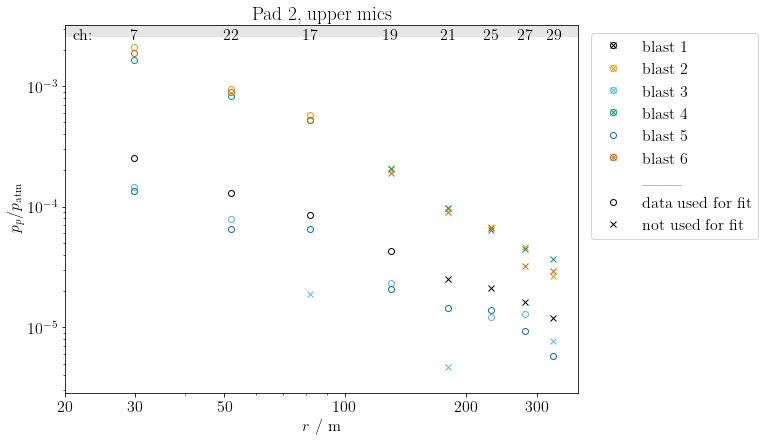

In [51]:
fig, ax = ppplot(idx, sel1.index, True)

#### lower mics

In [52]:
sel1 = sell.loc[sell['pad'] == 2]
idx = pd.Index([])

##### blast 1

In [53]:
sel2 = sel1.loc[sel1.blast == 1]
# sel3 = sel2.drop(index=228)
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.439e+00 +- 1.1e-01, Ea/Eb: 3.30e-06


##### blast 2

In [54]:
sel2 = sel1.loc[sel1.blast == 2]
# sel3 = sel2.loc[sel2.ch != 15]
sel3 = sel2.query('~r.isnull() & ch != 15 & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.400e+02 +- 5.7e+01, Ea/Eb: 1.24e-03


##### blast 3

In [55]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.498e-01 +- 5.5e-03, Ea/Eb: 5.72e-07


##### blast 4

In [56]:
sel2 = sel1.loc[sel1.blast == 4]
# sel3 = sel2.loc[sel2.ch != 15]
sel3 = sel2.query('~r.isnull() & ch != 15 & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.348e+02 +- 2.4e+01, Ea/Eb: 7.67e-04


##### blast 5

In [57]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.717e-01 +- 3.1e-03, Ea/Eb: 3.93e-07


##### blast 6

In [58]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & ch != 15 & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.436e+02 +- 4.5e+01, Ea/Eb: 7.87e-04


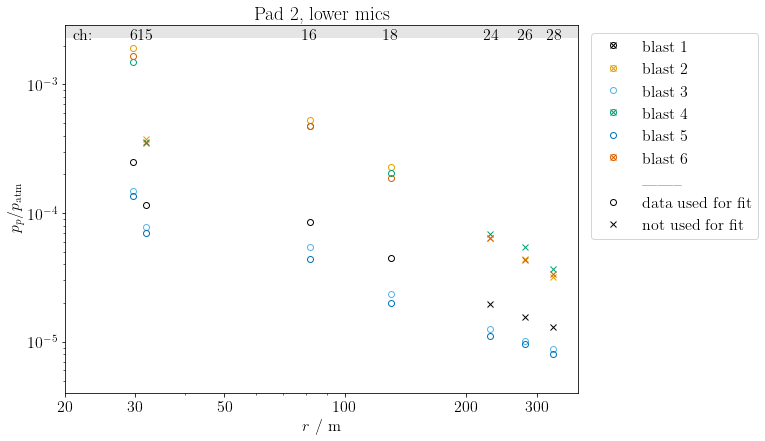

In [59]:
ppplot(idx, sel1.index)

### Pad 3

#### upper mics

In [60]:
sel1 = selh.loc[selh['pad'] == 3]
idx = pd.Index([])

##### blast 1

In [61]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.query('~r.isnull()', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.115e-01 +- 1.3e-02, Ea/Eb: 7.14e-07


##### blast 2

In [62]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, {Ea / EBLAST:.2e}")

Ea: 4.649e-01 +- 6.1e-03, 1.07e-06


##### blast 3

In [63]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.query('~r.isnull() & ch != 25 & ch != 27', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.079e+01 +- 2.9e-01, Ea/Eb: 4.76e-05


##### blast 4

In [64]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.533e-02 +- 3.2e-04, Ea/Eb: 1.04e-07


##### blast 5

In [65]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 6.851e-01 +- 1.3e-02, Ea/Eb: 1.57e-06


##### blast 6

In [66]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.721e-01 +- 1.2e-03, Ea/Eb: 3.94e-07


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


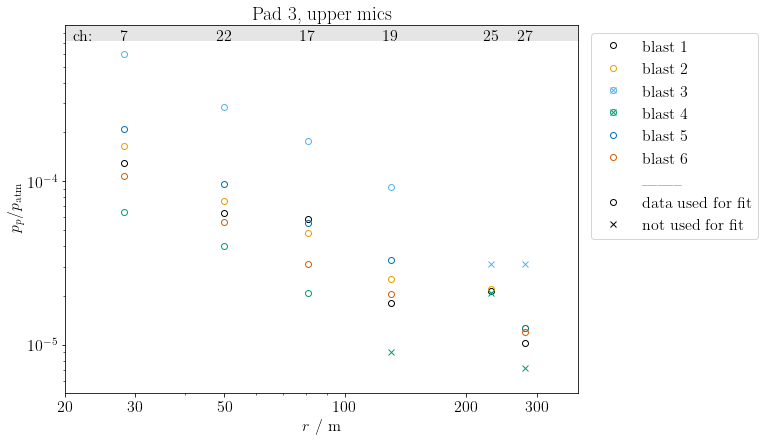

In [67]:
ppplot(idx, sel1.index)

#### lower mics

In [68]:
sel1 = sell.loc[sell['pad'] == 3]
idx = pd.Index([])

##### blast 1

In [69]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.633e-01 +- 2.5e-03, Ea/Eb: 3.74e-07


##### blast 2

In [70]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.775e-01 +- 7.4e-03, Ea/Eb: 8.65e-07


##### blast 3

In [71]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.022e+01 +- 3.2e-01, Ea/Eb: 2.34e-05


##### blast 4

In [72]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.643e-02 +- 1.0e-03, Ea/Eb: 1.06e-07


##### blast 5

In [73]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 9.299e-01 +- 2.0e-02, Ea/Eb: 2.13e-06


##### blast 6

In [74]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.348e-01 +- 3.3e-03, Ea/Eb: 3.09e-07


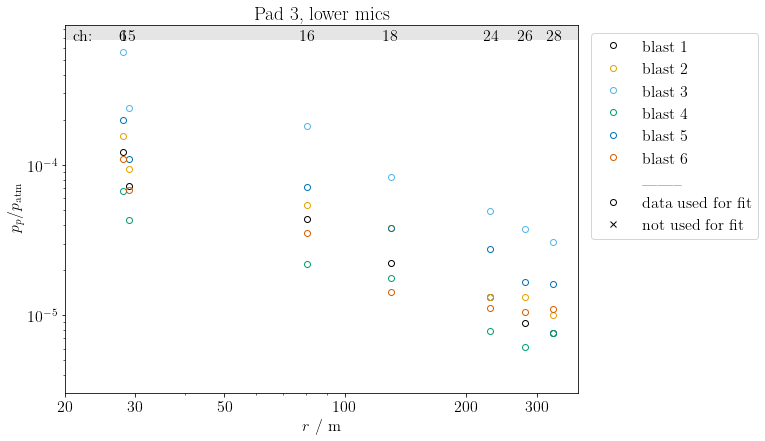

In [75]:
ppplot(idx, sel1.index)

### Pad4

#### upper mics

In [76]:
sel1 = selh.loc[selh['pad'] == 4]
idx = pd.Index([])

##### blast 1

In [77]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.234e+00 +- 2.2e-02, Ea/Eb: 2.83e-06


##### blast 2

In [78]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.201e+02 +- 1.1e+01, Ea/Eb: 5.04e-04


##### blast 3

In [79]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 7.558e-01 +- 1.2e-02, Ea/Eb: 1.73e-06


##### blast 4

In [80]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 8.181e+01 +- 2.0e+00, Ea/Eb: 1.87e-04


##### blast 5

In [81]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.442e+00 +- 6.6e-02, Ea/Eb: 5.59e-06


##### blast 6

In [82]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.682e+02 +- 4.8e+00, Ea/Eb: 3.85e-04


posx and posy should be finite values
posx and posy should be finite values


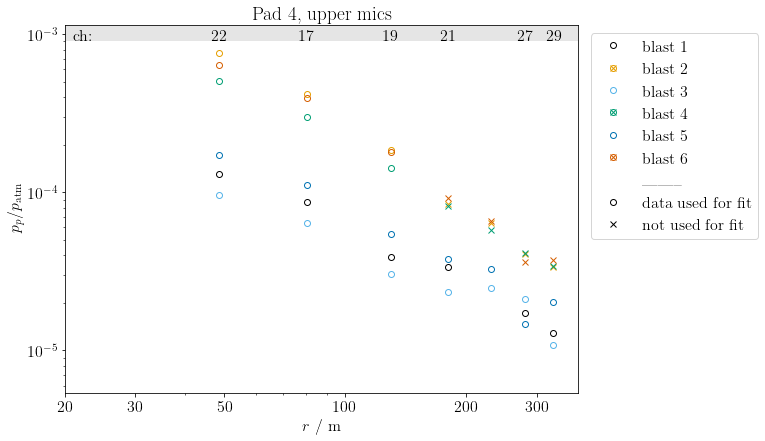

In [83]:
ppplot(idx, sel1.index)

#### lower mics

In [84]:
sel1 = sell.loc[sell['pad'] == 4]
idx = pd.Index([])

##### blast 1

In [85]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[sel2.ch != 15]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.537e+00 +- 1.7e-02, Ea/Eb: 3.52e-06


##### blast 2

In [86]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.query('ch != 15 & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.091e+02 +- 6.0e+00, Ea/Eb: 1.17e-03


##### blast 3

In [87]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[sel2.ch != 15]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 6.770e-01 +- 9.4e-03, Ea/Eb: 1.55e-06


##### blast 4

In [88]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('ch != 15 & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.296e+02 +- 1.6e-02, Ea/Eb: 2.97e-04


##### blast 5

In [89]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[sel2.ch != 15]
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.563e+00 +- 4.8e-02, Ea/Eb: 8.16e-06


##### blast 6

In [90]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('ch != 15 & r < 100', engine='python')
Ea, σEa = fit_inverse_pp_log(sel3)

if ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.166e+02 +- 2.9e+00, Ea/Eb: 7.25e-04


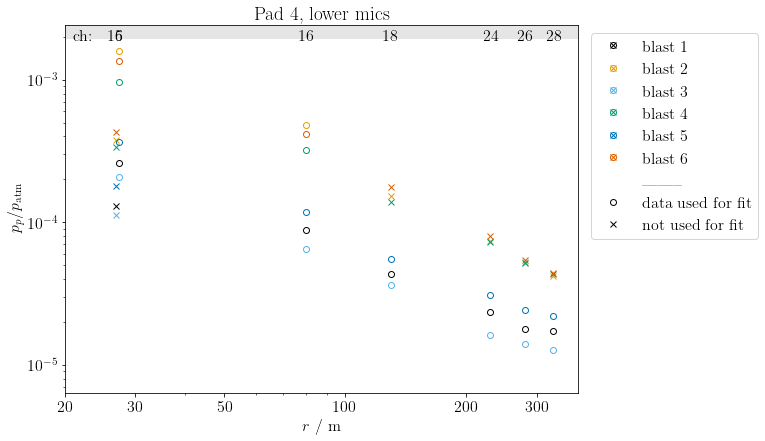

In [91]:
ppplot(idx, sel1.index)

## Impulse

$$
I_1 = \int_{t_s}^{t_1} p\,dt
$$

- Pressure scales with admospreic pressure: $\bar p = p / p_\text{a}$
- Time scales same as distances: $\bar t = t\,f_{t} E^{-1/3}$

$I_1$ can be written in terms of scaled variables an two conversion values:

$$
I_1 = \int_{t_s}^{t_1}p\,dt = \int_0^{\bar t_1}p_\text{a}\,\bar p\,f_{t}E^{1/3}\,d\bar t
\quad,\quad\text{where }
\bar t = \frac{t - t_s}{f_{t}E^{1/3}}
$$

The integral that contains only scaled time and pressure quantities is then defined as scaled impulse

$$
{\bar I}_1 = \int_0^{\bar t_1}\!\!{\bar p}\,d{\bar t}
= \frac{I_1}{p_\text{a}\,f_{t}E^{1/3}}
$$

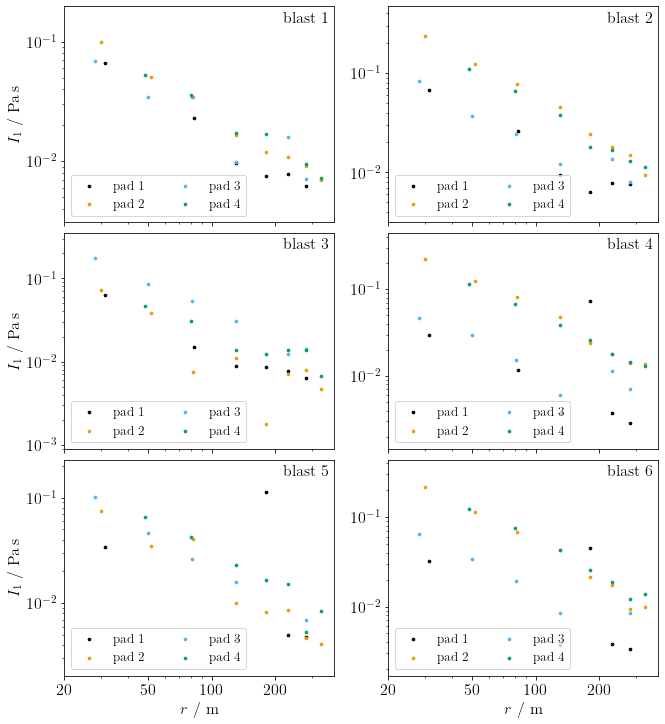

In [92]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True)

for ax, blast in zip(axs.flatten(), [1, 2, 3, 4, 5, 6]):
    ax.set_xscale('log'); ax.set_yscale('log')
    sel1 = selh.loc[selh.blast == blast]
    for pad in [1, 2, 3, 4]:
        sel2 = sel1.loc[sel1['pad'] == pad]
        ax.scatter(sel2.r, sel2.imp1, s=7, c=clrs[pad - 1], label=f'pad {pad}')
    ax.legend(loc='lower left', ncol=2, fontsize='small')
    ax.text(.98, .98, 'blast %i' % blast, ha='right', va='top',
            transform=ax.transAxes)
    mn = sel1.imp1.min()
    mn = 0.5 * mn if mn > 0. else 1e-3
    mx = sel1.imp1.max()
    mx = 1e0 if np.isnan(mx) else 2 * mx
    ax.set_ylim(mn, mx)
for ax in axs[-1, :]:
    tcks = [20, 50, 100, 200]
    ax.set_xticks(tcks)
    ax.set_xticklabels([r'$%d$' % tck for tck in tcks])
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
for ax in axs[:, 0]:
    ax.set_ylabel(r'$I_1\ /\ \mathrm{Pa\,s}$')
ax = axs[0, 0]
ax.set_xlim(20, 380)
fig.subplots_adjust(hspace=.05, top=.97, left=.075)
fig.set_size_inches(10, 11)

### Radial Impulse Dependency

Measured values fit an $r^{-1}$ model quite well
$$
I_1 = \frac{b}{r}
$$

The KG85 model provides and predicts a scaled impulse vs. scaled distance relationship

$$
\begin{align}
\bar I_1 &= \frac{f_t\,I_1}{p_\text{a}\,E^{1/3}} = \frac{a_\mathrm{ref}}{\bar r}
\quad,\quad
a_{I,\text{ref}} = 6.403\times10^{-8}\,\mathrm{m\,s\,J^{-2/3}} \\
I_1 &= \frac{b}{r} = p_\text{a}\,\frac{E^{1/3}}{f_t}\,\bar{I}_1
= \frac{p_\text{a}E^{1/3}}{f_t}\,\frac{a_{I,\text{ref}}}{\bar{r}}
= \frac{p_\text{a}E^{1/3}}{f_t}\frac{a_{I,\text{ref}}E^{1/3}}{f_dr}
\end{align}
$$

$$
\Rightarrow E = 
\Bigl(
    \frac{f_rf_t}{p_\text{a}}
    \frac{b}{a_{I,\text{ref}}}
\Bigr)^{3/2}
$$

For reference blast $f_d=1$.
For the experiments, $f_d$ is calculated from temperature, atmospheric pressure, and speed of sound (see notebooks `mics_c.ipynb`, `kestrel-data.ipynb`, `transmission-factor.ipynb`).

$a_{I,\text{ref}}$:

### `impplot()`

Plots $r^{-1}$ dependency of $I_1$

In [93]:
def impplot(idx1, idx2, ret: bool = False):
    return rplot(idx1, idx2, mode='i', ret=ret,
                 ylabel=r'$I_1 / \mathrm{Pa\,s}$')

### `fit_inverse_imp()`, `fit_inverse_imp_log()`

Get energies from peak fit to $I_1$.

**Uncertainties**:\
*For now* (...), neglect uncertainties in $a_{I,\text{ref}}$ and $p_\text{a}$, and
propagate $\sigma_b$ only

$$
E_\text{a} = \biggl(\frac{f_tf_d\,b}{a_{I,\text{ref}}\,p_\text{a}}\biggr)^{3/2}
\quad,\quad
\sigma_{E_\text{a}} = \frac{3}{2}\frac{E_\text{a}}{b}\,\sigma_b
$$

Uncertainty returned from `fit_inverse_imp_log()`:

$$Y = \ln I = \ln\frac{b}{r} = \ln b - \ln r = X_0 - X$$

- From fit: $\sigma_{X_0}$.
- $\sigma_Y^2 = \sigma_{X_0}^2 + \sigma_X^2$. For now, assume $\sigma_X=0$...
- $\sigma_b = e^{Y}\sigma_Y$

In [94]:
def fit_inverse_imp(sel, airef=txisi.impb_oorb_rolloff_const):
    res = curve_fit(inverse, sel.r, sel.imp1)
    b, σb = res[0][0], np.sqrt(res[1][0, 0])
    Ea = (b / (airef * pa)) ** 1.5
    σEa = 1.5 * Ea * σb / b
    return Ea, σEa

def fit_inverse_imp_log(sel, airef=txisi.impb_oorb_rolloff_const):
    res = curve_fit(lambda x, a: a - x, np.log(sel.r), np.log(sel.imp1))
    b = np.exp(res[0][0])
    σb = b * np.sqrt(np.abs(res[1][0, 0]))
    Ea = (b / (airef * pa)) ** 1.5
    σEa = 1.5 * Ea * σb / b
    return Ea, σEa

### Pad 1

#### lower mics

In [95]:
sel1 = sell.loc[sell['pad'] == 1]
idx = pd.Index([])

##### blast 1

In [96]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.951e+03 +- 4.7e+02, Ea/Eb: 1.13e-02


##### blast 2

In [97]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.275e+03 +- 4.6e+02, Ea/Eb: 1.21e-02


##### blast 3

In [98]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.107e+03 +- 4.1e+02, Ea/Eb: 1.17e-02


##### blast 4

In [99]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

idx = idx.append(sel3.index)
if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.990e+03 +- 1.9e+02, Ea/Eb: 4.56e-03


##### blast 5

In [100]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.092e+03 +- 1.3e+02, Ea/Eb: 4.79e-03


##### blast 6

In [101]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.808e+03 +- 2.0e+02, Ea/Eb: 4.14e-03


posx and posy should be finite values
posx and posy should be finite values


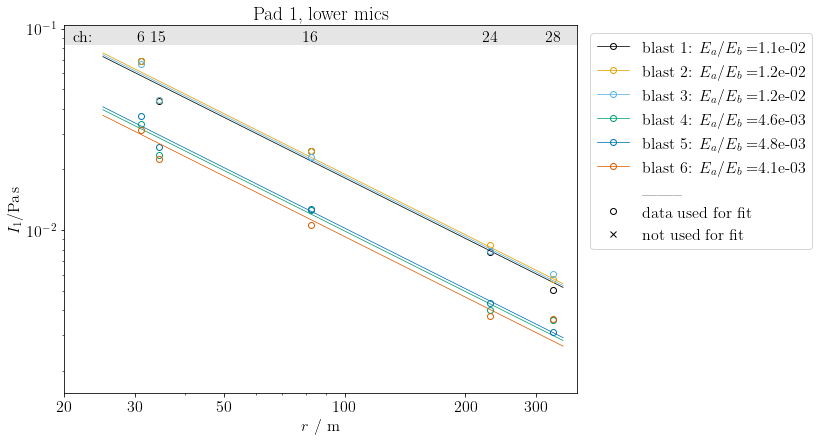

In [102]:
impplot(idx, sel1.index)

#### upper mics

In [103]:
sel1 = selh.loc[selh['pad'] == 1]
idx = pd.Index([])

##### blast 1

In [104]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 4.316e+03 +- 5.2e+02, Ea/Eb: 9.89e-03
     ch         r
36    7   31.2182
90   17   82.6694
102  19  130.2776
108  21  180.2006
126  25  230.1570
138  27  280.1290


##### blast 2

In [105]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 4.477e+03 +- 8.0e+02, Ea/Eb: 1.03e-02
     ch         r
37    7   31.2182
91   17   82.6694
103  19  130.2776
109  21  180.2006
127  25  230.1570
139  27  280.1290


##### blast 3

In [106]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 3.885e+03 +- 5.1e+02, Ea/Eb: 8.90e-03
     ch         r
38    7   31.2182
92   17   82.6694
104  19  130.2776
110  21  180.2006
128  25  230.1570
140  27  280.1290


##### blast 4

For blasts 4-6, channels 19 and 21 are kinda problematic

In [107]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & ch != 19 & ch != 21', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 1.705e+03 +- 1.1e+02, Ea/Eb: 3.91e-03
     ch         r
39    7   31.2182
93   17   82.6694
129  25  230.1570
141  27  280.1290


##### blast 5

In [108]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.query('~r.isnull() & ch != 19 & ch != 21', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 2.594e+03 +- 2.5e+02, Ea/Eb: 5.94e-03
     ch         r
40    7   31.2182
130  25  230.1570
142  27  280.1290


##### blast 6

In [109]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & ch != 19 & ch != 21', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 1.848e+03 +- 9.5e+01, Ea/Eb: 4.23e-03
     ch         r
41    7   31.2182
131  25  230.1570
143  27  280.1290


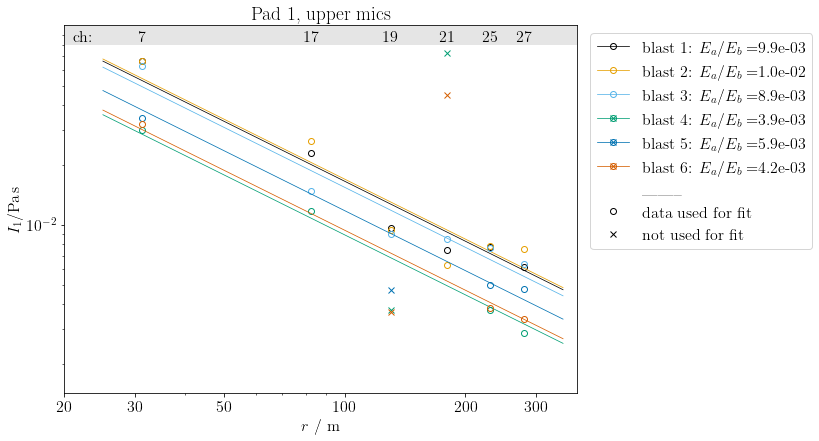

In [110]:
fig, ax = impplot(idx, sel1.index, ret=True)

In [111]:
1 / (np.log(10) * 2.15)

0.20199743344337295

In [112]:
b1 = (10 ** 2.48) / (txisi.p0 * TNTOT ** 2)
b3 = 1 / (TNTOT * np.log(10) * 2.15)
print(f"b1={b1:.3e}, b3={b3:.3e}")

def ford(dbar, rbar):
    fac1 = b1 / rbar
    fac2 = np.exp(-dbar / b3)
    fac3 = (1 + np.exp(-10 * dbar / b3)) ** 0.1
    print(f"{fac1=}, {fac2=}, {fac3=}")
    return fac1 * fac2 / fac3

b1=1.148e-07, b3=1.254e-03


In [113]:
ford(0, xp / ETOT)

fac1=array([3.48292143e-07, 2.48780102e-08]), fac2=1.0, fac3=1.0717734625362931


array([3.24968060e-07, 2.32120043e-08])

fac1=array([3.48292143e-07, 2.48780102e-08]), fac2=0.9233266894033694, fac3=1.0378806081492171


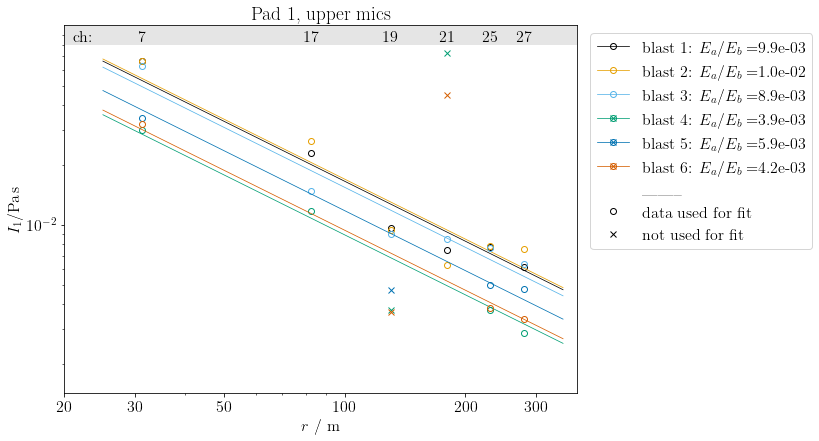

In [114]:
ax.plot(xp, ford(1e-4, xp / ETOT) * ETOT)
fig

### Pad 2

#### lower mics

In [115]:
sel1 = sell.loc[sell['pad'] == 2]
idx = pd.Index([])

##### blast 1

In [116]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 7.896e+03 +- 6.1e+02, Ea/Eb: 1.81e-02


##### blast 2

In [117]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.006e+04 +- 3.6e+03, Ea/Eb: 4.60e-02


##### blast 3

In [118]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.286e+03 +- 5.1e+02, Ea/Eb: 1.21e-02


##### blast 4

In [119]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.295e+04 +- 3.5e+03, Ea/Eb: 5.26e-02


##### blast 5

In [120]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 5.051e+03 +- 4.3e+02, Ea/Eb: 1.16e-02


##### blast 6

In [121]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.930e+04 +- 3.2e+03, Ea/Eb: 4.42e-02


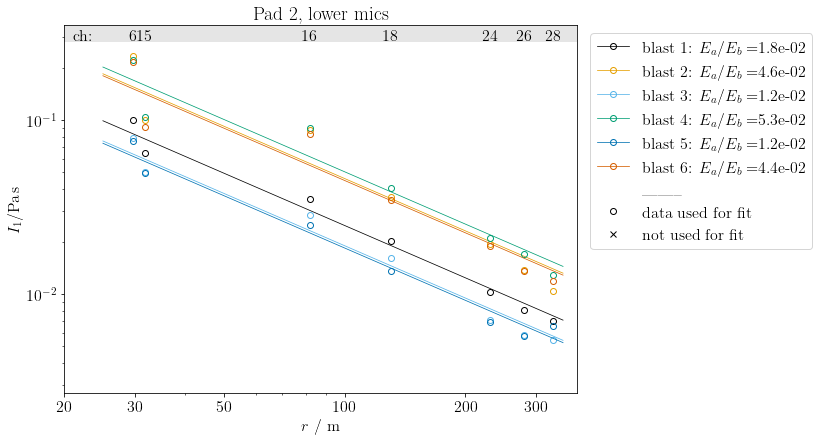

In [122]:
impplot(idx, sel1.index)

#### upper mics

In [123]:
sel1 = selh.loc[selh['pad'] == 2]
idx = pd.Index([])

##### blast 1

In [124]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 7.919e+03 +- 4.9e+02, Ea/Eb: 1.81e-02
     ch         r
192   7   29.7827
240  17   81.9541
252  19  130.2776
258  21  180.2006
264  22   51.8393
276  25  230.1570
288  27  280.1290
300  29  330.1095


##### blast 2

In [125]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.query('~r.isnull() & r < 155', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 3.262e+04 +- 1.6e+03, Ea/Eb: 7.47e-02
     ch         r
193   7   29.7827
241  17   81.9541
253  19  130.2776
265  22   51.8393


In [126]:
sel3[['pad', 'blast', 'ch', 'r', 'ppf46', 'imp1', 'Ea']]

pad  blast  ch         r     ppf46    imp1  Ea
193    2      2   7   29.7827  207.3664  0.2335 NaN
241    2      2  17   81.9541   55.9016  0.0778 NaN
253    2      2  19  130.2776   20.4305  0.0455 NaN
265    2      2  22   51.8393   93.2065  0.1218 NaN

##### blast 3

needs cleanup first

##### blast 4

In [127]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 3.337e+04 +- 6.7e+02, Ea/Eb: 7.64e-02
     ch         r
195   7   29.7827
243  17   81.9541
255  19  130.2776
267  22   51.8393


##### blast 5

In [128]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.query('~r.isnull() & ch != 17', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 4.137e+03 +- 5.0e+02, Ea/Eb: 9.48e-03
     ch         r
196   7   29.7827
256  19  130.2776
262  21  180.2006
268  22   51.8393
280  25  230.1570
292  27  280.1290
304  29  330.1095


##### blast 6

In [129]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 2.892e+04 +- 1.6e+03, Ea/Eb: 6.62e-02
     ch         r
197   7   29.7827
245  17   81.9541
257  19  130.2776
269  22   51.8393


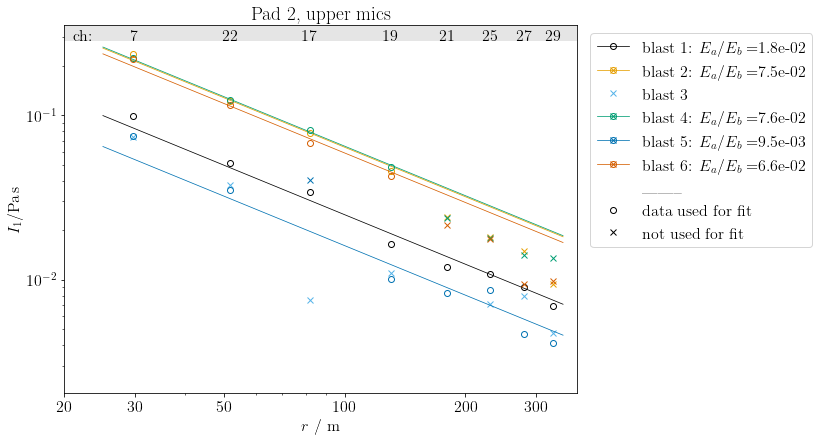

In [130]:
fig, ax = impplot(idx, sel1.index, True)

### Pad 3

#### lower mics

In [131]:
sel1 = sell.loc[sell['pad'] == 3]
idx = pd.Index([])

##### blast 1

In [132]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.624e+03 +- 3.1e+02, Ea/Eb: 1.06e-02


##### blast 2

In [133]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 6.362e+03 +- 6.4e+02, Ea/Eb: 1.46e-02


##### blast 3

In [134]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.701e+04 +- 1.7e+03, Ea/Eb: 3.90e-02


##### blast 4

In [135]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 3.664e+03 +- 4.5e+02, Ea/Eb: 8.39e-03


##### blast 5

In [136]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 9.035e+03 +- 9.9e+02, Ea/Eb: 2.07e-02


##### blast 6

In [137]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 4.226e+03 +- 5.6e+02, Ea/Eb: 9.68e-03


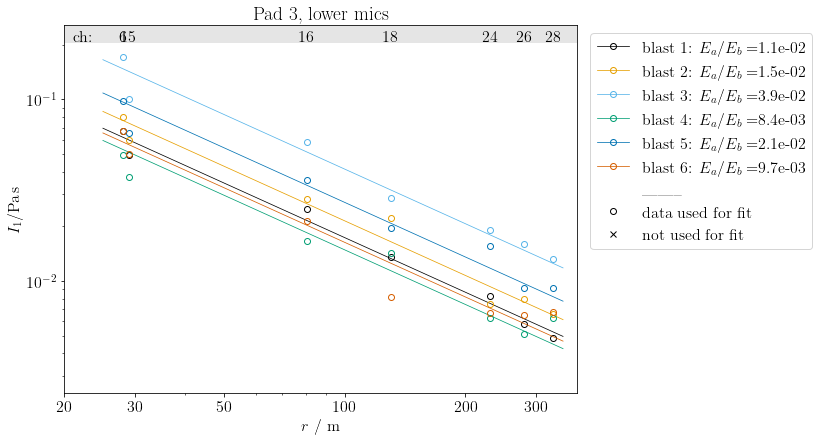

In [138]:
impplot(idx, sel1.index)

#### upper mics

In [139]:
sel1 = selh.loc[selh['pad'] == 3]
idx = pd.Index([])

##### blast 1

In [140]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 6.173e+03 +- 1.4e+03, Ea/Eb: 1.41e-02
     ch         r
342   7   28.0794
396  17   80.7116
408  19  130.2776
420  22   49.7770
432  25  230.1570
444  27  280.1290


##### blast 2

In [141]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 6.277e+03 +- 9.1e+02, Ea/Eb: 1.44e-02
     ch         r
343   7   28.0794
397  17   80.7116
409  19  130.2776
421  22   49.7770
433  25  230.1570
445  27  280.1290


##### blast 3

needs cleanup first

In [142]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 1.610e+04 +- 1.8e+03, Ea/Eb: 3.69e-02
     ch         r
344   7   28.0794
398  17   80.7116
410  19  130.2776
422  22   49.7770
434  25  230.1570
446  27  280.1290


##### blast 4

In [143]:
sel2 = sel1.loc[sel1.blast == 4]
# sel3 = sel2.loc[~np.isnan(sel2.r)]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 3.129e+03 +- 2.4e+02, Ea/Eb: 7.17e-03, σEa/Eb 5.61e-04
     ch        r
345   7  28.0794
399  17  80.7116
423  22  49.7770


##### blast 5

In [144]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 6.791e+03 +- 6.8e+02, Ea/Eb: 1.56e-02
     ch         r
346   7   28.0794
400  17   80.7116
412  19  130.2776
424  22   49.7770
448  27  280.1290


##### blast 6

In [145]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & r < 100', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 4.413e+03 +- 3.0e+02, Ea/Eb: 1.01e-02, σEa/Eb 6.93e-04
     ch        r
347   7  28.0794
401  17  80.7116
425  22  49.7770


posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values


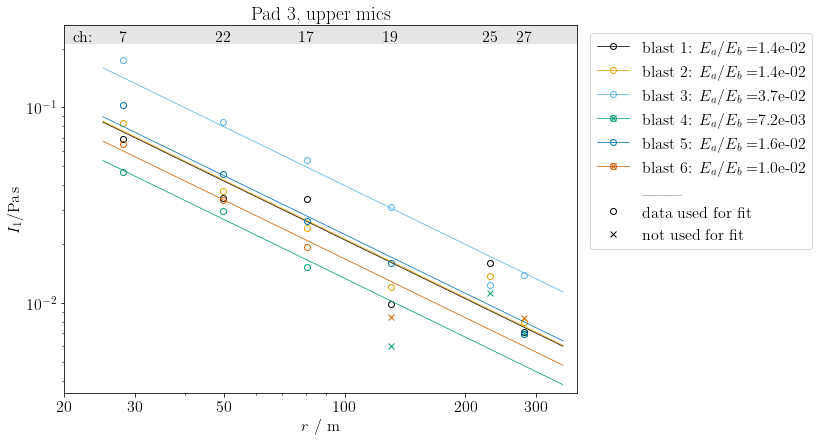

In [146]:
impplot(idx, sel1.index)

### Pad 4

#### lower mics

In [147]:
sel1 = sell.loc[sell['pad'] == 4]
idx = pd.Index([])

##### blast 1

In [148]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 8.931e+03 +- 7.9e+02, Ea/Eb: 2.05e-02


##### blast 2

In [149]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.926e+04 +- 3.2e+03, Ea/Eb: 4.41e-02


##### blast 3

In [150]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 7.023e+03 +- 5.3e+02, Ea/Eb: 1.61e-02


##### blast 4

In [151]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.308e+04 +- 3.0e+03, Ea/Eb: 5.29e-02


##### blast 5

In [152]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 1.200e+04 +- 1.1e+03, Ea/Eb: 2.75e-02


##### blast 6

In [153]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.loc[~np.isnan(sel2.r)]
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}")

Ea: 2.482e+04 +- 3.4e+03, Ea/Eb: 5.69e-02


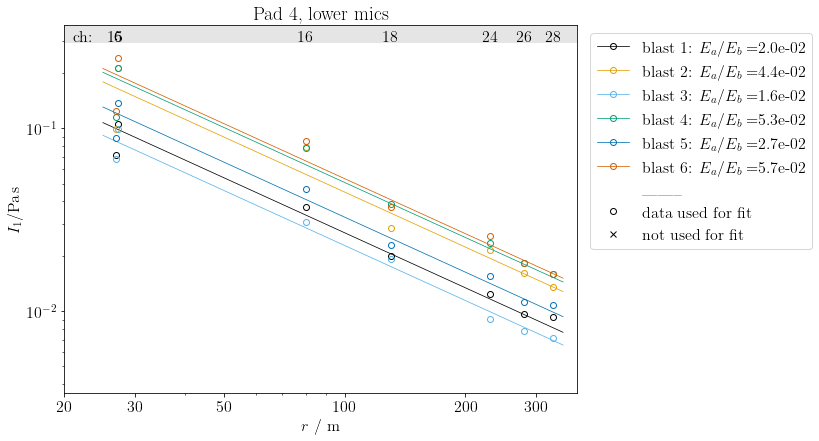

In [154]:
impplot(idx, sel1.index)

#### upper mics

In [155]:
sel1 = selh.loc[selh['pad'] == 4]
idx = pd.Index([])

##### blast 1

In [156]:
sel2 = sel1.loc[sel1.blast == 1]
sel3 = sel2.query('~r.isnull() & r < 200', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 8.734e+03 +- 9.1e+02, Ea/Eb: 2.00e-02, σEa/Eb 2.09e-03
     ch         r
546  17   80.2200
558  19  130.2776
564  21  180.2006
570  22   48.5635


##### blast 2

In [157]:
sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 2.363e+04 +- 7.9e+02, Ea/Eb: 5.41e-02, σEa/Eb 1.82e-03
     ch         r
547  17   80.2200
559  19  130.2776
571  22   48.5635


##### blast 3

In [158]:
sel2 = sel1.loc[sel1.blast == 3]
sel3 = sel2.query('~r.isnull() & r < 200', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 6.401e+03 +- 6.4e+02, Ea/Eb: 1.47e-02, σEa/Eb 1.48e-03
     ch         r
548  17   80.2200
560  19  130.2776
566  21  180.2006
572  22   48.5635


##### blast 4

In [159]:
sel2 = sel1.loc[sel1.blast == 4]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 2.521e+04 +- 9.6e+02, Ea/Eb: 5.78e-02, σEa/Eb 2.20e-03
     ch         r
549  17   80.2200
561  19  130.2776
573  22   48.5635


##### blast 5

In [160]:
sel2 = sel1.loc[sel1.blast == 5]
sel3 = sel2.query('~r.isnull() & r < 200', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 1.118e+04 +- 5.5e+02, Ea/Eb: 2.56e-02, σEa/Eb 1.25e-03
     ch         r
550  17   80.2200
562  19  130.2776
568  21  180.2006
574  22   48.5635


##### blast 6

In [161]:
sel2 = sel1.loc[sel1.blast == 6]
sel3 = sel2.query('~r.isnull() & r < 150', engine='python')
Ea, σEa = fit_inverse_imp_log(sel3)

if not ea_use_pp:
    summ.loc[sel3.index, 'Ea'] = Ea
    summ.loc[sel3.index, 'σEa'] = σEa
idx = idx.append(sel3.index)
print(f"Ea: {Ea:.3e} +- {σEa:.1e}, Ea/Eb: {Ea / EBLAST:.2e}, σEa/Eb {σEa / EBLAST:.2e}")
print(sel3[['ch', 'r']])

Ea: 2.880e+04 +- 1.1e+03, Ea/Eb: 6.60e-02, σEa/Eb 2.52e-03
     ch         r
551  17   80.2200
563  19  130.2776
575  22   48.5635


posx and posy should be finite values
posx and posy should be finite values


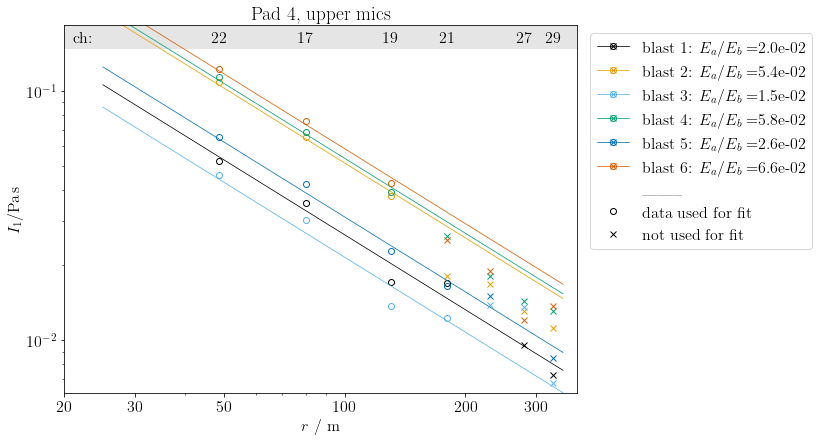

In [162]:
impplot(idx, sel1.index)

In [163]:
plt.close('all')

## Example: Pad 2 

### Effect of reference data on energy estimate

The KG85 impulse interpolation is a bit whacky.

- As default I use a corrected interpolation value that best fits the data
  provided in the book. It could be a typo. Don't know...
  
Here is a comparison

Different slopes of the $r^{-1}$ trend

In [164]:
txisi.impb_oorb_rolloff_const, txisi_orig.impb_oorb_rolloff_const

(6.403726982135217e-08, 7.461734048748861e-08)

Fit to upper mics

In [165]:
sel1 = selh.loc[selh['pad'] == 2]
sel2 = sel1.loc[sel1.blast == 2]

In [166]:
selpp1 = sel2.loc[sel2.r < 100]
selpp2 = sel2.loc[~np.isnan(sel2.r)]
selim1 = sel2.loc[~np.isnan(sel2.r)]
selim2 = sel2.loc[sel2.r < 150]

Eapp1, σEapp1 = fit_inverse_pp_log(selpp2)
Eaim1, σEaim1 = fit_inverse_imp_log(selim2, airef=airef)
Eaim2, σEaim2 = fit_inverse_imp_log(selim2, airef=airef)
Eaim3, σEaim3 = fit_inverse_imp_log(selim2, airef=airef_orig)

In [167]:
print(
    f"pp:\n"
    f"  Ea:     {Eapp1:.3e} +- {σEapp1:.2e}")
print(
    f"imp:\n"
    f"  Eaimp1: {Eaim1:.3e} +- {σEaim1:.2e}\n"
    f"  Eaimp2: {Eaim2:.3e} +- {σEaim2:.2e}\n"
    f"  Eaimp3: {Eaim3:.3e} +- {σEaim3:.2e}")

pp:
  Ea:     1.077e+02 +- 2.07e+01
imp:
  Eaimp1: 3.262e+04 +- 1.61e+03
  Eaimp2: 3.262e+04 +- 1.61e+03
  Eaimp3: 2.594e+04 +- 1.28e+03


### Blast 2, peak pressure vs. impulse

In [168]:
airef, airef_orig

(6.403726982135217e-08, 7.461734048748861e-08)

In [169]:
selpp1 = sel2.loc[sel2.r < 100]
selpp2 = sel2.loc[~np.isnan(sel2.r)]
selim1 = sel2.loc[~np.isnan(sel2.r)]
selim2 = sel2.loc[sel2.r < 150]

Eapp1, σEapp1 = fit_inverse_pp_log(selpp1)
Eapp2, σEapp2 = fit_inverse_pp_log(selpp2)
Eaim1, σEaim1 = fit_inverse_imp_log(selim1)
Eaim2, σEaim2 = fit_inverse_imp_log(selim2)
Eaim3, σEaim3 = fit_inverse_imp_log(selim2, airef=airef_orig)

In [170]:
print(
    f"pp:\n"
    f"  Eapp1:  {Eapp1:.3e} +- {σEapp1:.2e}\n"
    f"  Eapp2:  {Eapp2:.3e} +- {σEapp2:.2e}")
print(
    f"imp:\n"
    f"  Eaimp1: {Eaim1:.3e} +- {σEaim1:.2e}, Eaimp1 / EBLAST: {Eaim1 / EBLAST:.2e}\n"
    f"  Eaimp2: {Eaim2:.3e} +- {σEaim2:.2e}, Eaimp2 / EBLAST: {Eaim2 / EBLAST:.2e}\n"
    f"  Eaimp3: {Eaim3:.3e} +- {σEaim3:.2e}, Eaimp3 / EBLAST: {Eaim3 / EBLAST:.2e}\n")

pp:
  Eapp1:  1.086e+03 +- 2.76e+01
  Eapp2:  1.077e+02 +- 2.07e+01
imp:
  Eaimp1: 2.264e+04 +- 3.40e+03, Eaimp1 / EBLAST: 5.19e-02
  Eaimp2: 3.262e+04 +- 1.61e+03, Eaimp2 / EBLAST: 7.47e-02
  Eaimp3: 2.594e+04 +- 1.28e+03, Eaimp3 / EBLAST: 5.94e-02



In [171]:
Eaim2 / Eapp1

30.03236648046472

In [172]:
Eaim2 / EBLAST, Eaim3 / EBLAST

(0.07473371066914068, 0.05941636917088609)

In [173]:
Eapp1 / EBLAST

0.002488438955276902

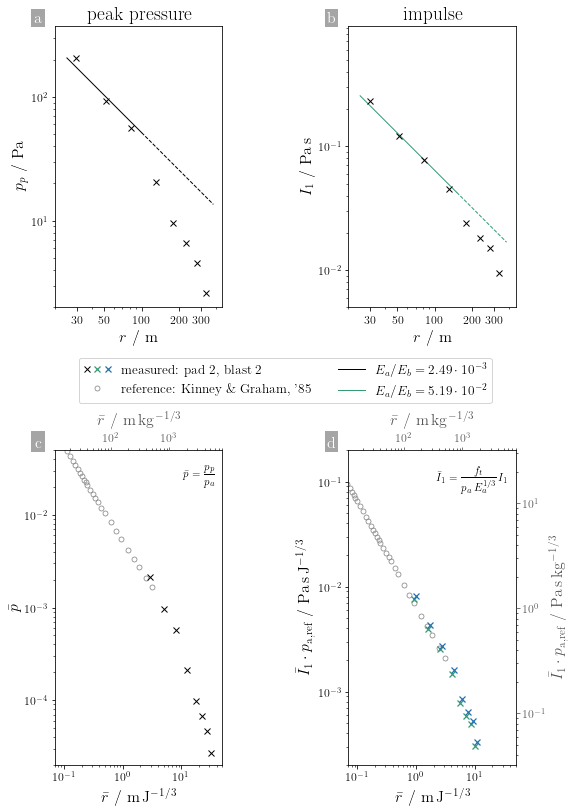

In [174]:
a_ir = txisi.impb_oorb_rolloff_const

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(6, 9))
ax1, ax2, ax3, ax4 = axs.flatten()

for ax, abcd in zip(axs.flatten(), 'abcd'):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.tick_params(axis='both', labelsize=12)
    ax.add_artist(plt.Rectangle(
        (-.14, .995), .08, .065, transform=ax.transAxes,
        ec='none', fc='#a5a5a5', lw=.5, clip_on=False))
    ax.text(-.1, 1., s=abcd, ha='center', va='bottom', transform=ax.transAxes,
            color='white')

for ax in (ax1, ax2):
    ax.set_aspect(1)
    ax.set_xlim(20, 450)
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
    ax.set_xticks([30, 50, 100, 200, 300])
    ax.set_xticklabels([str(lbl) for lbl in ax.get_xticks()])

for ax in (ax3, ax4):
    ax.set_xlabel(r'$\bar{r}\ /\ \mathrm{m\,J^{-1/3}}$')
ax1.set_ylabel(r'$p_p\ /\ \mathrm{Pa}$')
ax2.set_ylabel(r'$I_1\ /\ \mathrm{Pa\,s}$')
ax3.set_ylabel(r'$\bar{p}$')
ax4.set_ylabel(r'$\bar{I}_1\cdot p_\text{a,ref}\ /\ \mathrm{Pa\,s\,J^{-1/3}}$')

ax1.set_ylim(2, 375); ax2.set_ylim(5e-3, .94)
ax3.set_xlim(7e-2, 50); ax3.set_ylim(2e-5, 5e-2)
ax4.set_xlim(7e-2, 50); ax4.set_ylim(2e-4, 2e-1)

ax3b, ax4a, ax4b = ax3.twiny(), ax4.twinx(), ax4.twiny()
for (ax, parax) in ((ax3b, ax3), (ax4b, ax4)):
    ax.set_xscale('log')
    ax.set_xticks(
        np.concatenate(
            (np.arange(2e1, 1e2, 1e1), np.arange(2e2, 1e3, 1e2),
             np.arange(2e3, 9e3, 1e3))),
        minor=True)
    ax.set_xticks([1e1, 1e2, 1e3], minor=False)
    ax.tick_params(axis='x', colors='#555555', labelsize=12)
    ax.xaxis.label.set_color('#555555')
    ax.set_xlim([el * TNTOT for el in parax.get_xlim()])
    ax.set_xlabel(r'$\bar{r}\ /\ \mathrm{m\,kg^{-1/3}}$', labelpad=8)
for ax in (ax3b, ax4a, ax4b):
    for side in ('left', 'top', 'right', 'bottom'):
        ax.spines[side].set_visible(False)
    
ax4a.set_yscale('log')
ax4a.tick_params(axis='y', colors='#555555', labelsize=12)
ax4a.yaxis.label.set_color('#555555')
ax4a.set_ylim([el * TNTOT for el in ax4.get_ylim()])
ax4a.set_ylabel(r'$\bar{I}_1\cdot p_\text{a,ref}\ /\ \mathrm{Pa\,s\,kg^{-1/3}}$')

rp = txisi.data.Z

ppp, = ax1.plot(sel2.r, sel2.ppf46, 'xk')
ax2.plot(sel2.r, sel2.imp1, 'xk', zorder=10)
ppp2, = ax3.plot(sel2.r * (Eapp1 ** -ot), sel2.ppf46 / pa,
         'x', ms=6, mew=1, color=clrs[0], zorder=10)
txi, = ax3.plot(rp, txisi.pbar(rp), 'o',
                mec='#858585', mfc='none', ms=5, mew=.75)
impp, = ax4.plot(sel2.r * Eaim2 ** -ot, sel2.imp1 * txisi.p0 / (pa * Eaim2 ** ot),
                 'x', ms=6, mew=1.25, mec=pltt[2], zorder=10)
impp3, = ax4.plot(sel2.r * Eaim3 ** -ot, sel2.imp1 * txisi.p0 / (pa * Eaim3 ** ot),
                  'x', ms=6, mew=1.25, mec=pltt[0], zorder=10)
ax4.plot(rp, txisi.imp1(rp) * txisi.p0,
         'o', mec='#858585', mfc='none', ms=5, mew=.75)
xp1, xp2 = np.array([25, 100]), np.array([100, 380])
l1, = ax1.plot(xp1, inverse(xp1, aref * Eapp1 ** ot * pa),
               lw=1, color=clrs[0], zorder=1)
ax1.plot(xp2, inverse(xp2, aref * Eapp1 ** ot * pa),
         lw=1, color=clrs[0], zorder=1, ls='dashed')
xp1, xp2 = np.array([25, 150]), np.array([150, 380])
l4, = ax2.plot(xp1, inverse(xp1, Eaim2 ** (2 / 3) * a_ir * pa),
               color=pltt[2], lw=1, zorder=1)
ax2.plot(xp2, inverse(xp2, Eaim2 ** (2 / 3) * a_ir * pa),
         color=pltt[2], lw=1, ls='dashed', zorder=1)

ax1.set_title(r'peak pressure')
ax2.set_title(r'impulse')
ax3.text(.95, .95, s=r'$\displaystyle\bar{p} = \frac{p_p}{p_a}$',
         ha='right', va='top', fontsize=11, transform=ax3.transAxes)
ax4.text(x=.95, y=.95,
         s=r'$\displaystyle\bar{I}_1=\frac{f_{t}}{p_a\,E_a^{1/3}}I_1$',
         ha='right', va='top', fontsize=11, transform=ax4.transAxes)

leg = fig.legend(
    handles=[(ppp, impp, impp3), txi, l1, l4],
    labels=[
        'measured: pad 2, blast 2', "reference: Kinney \& Graham, '85",
        fr'$E_a/E_b={format_pow10(Eapp1 / EBLAST)}$',
        fr'$E_a/E_b={format_pow10(Eaim1 / EBLAST)}$'
    ],
    numpoints=1, loc='center', bbox_to_anchor=(.5, .52),
    handler_map={tuple: HandlerTuple(ndivide=None)},
    bbox_transform=fig.transFigure, ncol=2, handlelength=2,
    fontsize='small'
)
fig.subplots_adjust(bottom=.075, left=.1, top=.95, right=.9,
                    wspace=.75, hspace=.4)
fig.set_size_inches(8, 12)

In [175]:
sel2a = sel2.loc[sel2.r <= 135]
sel2a

pad  ch  blast    pmax   tmax   pmin   tmin   noise      ts    tarr  ...  \
193    2   7      2  244.30  1.393 -75.21  1.397  0.2290  1.3934  1.3934  ...   
241    2  17      2   76.14  1.542 -23.04  1.547  0.2275  1.5421  1.5422  ...   
253    2  19      2   18.84  1.699 -19.57  1.702  0.0091  1.6959  1.6962  ...   
265    2  22      2  118.10  1.471 -38.23  1.475  0.0232  1.4707  1.4707  ...   

     hlabel     ppf46  alpha  depth    dbar  dredbar    t         c  Ea  σEa  
193       h  207.3664   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN  NaN  
241       h   55.9016   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN  NaN  
253       h   20.4305   0.05    0.6  0.0079   0.0027  0.5  344.9806 NaN  NaN  
265       h   93.2065   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN  NaN  

[4 rows x 31 columns]

In [176]:
sel2b = sel2.loc[sel2.r > 135]
sel2b

pad  ch  blast   pmax   tmax   pmin   tmin   noise      ts    tarr  ...  \
259    2  21      2  9.340  1.860 -4.721  1.868  0.1425  1.8595  1.8596  ...   
277    2  25      2  5.526  1.976 -3.890  1.982     NaN  1.9732  1.9735  ...   
289    2  27      2  3.682  2.125 -2.019  2.133  0.2684  2.1229  2.1232  ...   
301    2  29      2  2.256  2.265 -2.003  2.271  0.1218  2.2609  2.2613  ...   

     hlabel   ppf46  alpha  depth    dbar  dredbar    t         c  Ea  σEa  
259       h  9.6142   0.05    0.6  0.0079   0.0028  0.5  344.9806 NaN  NaN  
277       h  6.5755   0.05    0.6  0.0079   0.0031  0.5  344.9806 NaN  NaN  
289       h  4.5344   0.05    0.6  0.0079   0.0032  0.5  344.9806 NaN  NaN  
301       h  2.6144   0.05    0.6  0.0079   0.0033  0.5  344.9806 NaN  NaN  

[4 rows x 31 columns]

In [177]:
pltt

[(0.13333333333333333, 0.44313725490196076, 0.6980392156862745),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.20784313725490197, 0.6078431372549019, 0.45098039215686275),
 (0.8862745098039215, 0.00392156862745098, 0.20392156862745098),
 (0.6431372549019608, 0.00392156862745098, 0.13333333333333333),
 (0.0, 0.0, 0.0)]

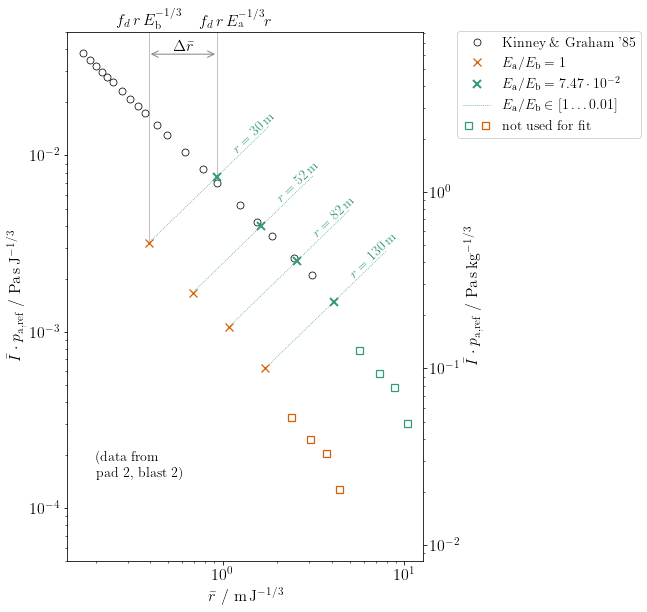

In [178]:
a_ir = txisi.impb_oorb_rolloff_const

fig, axi = plt.subplots()
axi.set_xscale('log'); axi.set_yscale('log')
# axi.set_aspect(1)
axi2 = axi.twinx()
for side in ('left', 'top', 'right', 'bottom'):
    axi2.spines[side].set_visible(False)

rp = txisi.data.Z[85:]
x = np.array([1, .03, .01])
ylim = np.array([5e-5, 5e-2])
axi2.set_yscale('log')
axi2.set_ylim(ylim * TNTOT)
axi.set_ylim(ylim)
# Eaim2 ** ot
fitds, = axi.plot(
    sel2a.r / Eaim2 ** ot, txisi.p0 * sel2a.imp1 / (pa * Eaim2 ** ot),
    'x', ms=8, mew=2, mec=pltt[2], zorder=10,
    
)
igd1, = axi.plot(
    sel2b.r / Eaim2 ** ot, txisi.p0 * sel2b.imp1 / (pa * Eaim2 ** ot),
    's', ms=7, mew=1.25, mec=pltt[2], mfc='none', zorder=10
)
for rr, iimp in zip(sel2a.r, sel2a.imp1):
    impp3, = axi.plot(
        rr / (x * EBLAST) ** ot, txisi.p0 * iimp / (pa * (x * EBLAST) ** ot),
        ls='dotted', lw=.75, color=pltt[2], zorder=0)
    axi.text(
        .95 * rr / (x[1] * EBLAST) ** ot, txisi.p0 * iimp / (pa * (x[1] * EBLAST) ** ot),
        s=r'$r=%.0f\,\mathrm{m}$' % rr, color=pltt[2], fontsize=14,
        rotation=44, rotation_mode='anchor')
fitdr, = axi.plot(
    sel2a.r / ETOT, txisi.p0 * sel2a.imp1 / (pa * ETOT),
    'x', ms=8, mew=1.25, mec=pltt[1], zorder=2
)
igd2, = axi.plot(sel2b.r / ETOT, txisi.p0 * sel2b.imp1 / (pa * ETOT),
                's', ms=7, mew=1.25, mec=pltt[1], mfc='none', zorder=2)
kgd, = axi.plot(
    rp, txisi.p0 * txisi.imp1(rp),
    'o', mec='k', mfc='none', ms=7, mew=.75, zorder=1)
r0, i0 = sel2.r.iloc[0], sel2.imp1.iloc[0]
axi.vlines(
    x=[r0 / ETOT, r0 / Eaim2 ** ot],
    ymin=[txisi.p0 * i0 / (pa * ETOT), txisi.p0 * i0 / (pa * Eaim2 ** ot)],
    ymax=1.01 * ylim[1],
    lw=.5, color='#858585', zorder=-1)
axi.text(.46 * r0 * (ETOT ** -1 + Eaim2 ** -ot), .75 * ylim[1],
         s=r'$\Delta \bar{r}$', ha='center', va='bottom')
axi.annotate(
    '', xy=(r0 / ETOT, .75 * ylim[1]), xytext=(r0 / Eaim2 ** ot, .75 * ylim[1]),
    arrowprops=dict(arrowstyle='<->', color='#858585')
)
axi.text(r0 / ETOT, 1.05 * ylim[1], s=r'$f_d\,r\,E_\text{b}^{-1/3}$',
         ha='center', va='bottom')
axi.text(1.25 * r0 / Eaim2 ** ot, 1.05 * ylim[1], ha='center', va='bottom',
        s=r'$f_d\,r\,E_\text{a}^{-1/3}r$')
axi.text(2e-1, 1.5e-4, '(data from\npad 2, blast 2)', fontsize=14)
axi.set_xlabel(r'$\bar{r}\ /\ \mathrm{m\,J^{-1/3}}$')
axi.set_ylabel(r'$\bar{I}\cdot p_\text{a,ref}\ /\ \mathrm{Pa\,s\,J^{-1/3}}$')
axi2.set_ylabel(r'$\bar{I}\cdot p_\text{a,ref}\ /\ \mathrm{Pa\,s\,kg^{-1/3}}$')

axi.legend(
    [kgd, fitdr, fitds, impp3, (igd1, igd2)],
    [
        r"Kinney \& Graham '85",
        r'$E_\text{a}/E_\text{b}=1$',
        r'$E_\text{a}/E_\text{b}=%s$' % format_pow10(Eaim2 / EBLAST),
        r'$E_\text{a}/E_\text{b} \in [1\dots0.01]$',
        r'not used for fit'
    ],
    handler_map={tuple: HandlerTuple(ndivide=None)},
    loc='upper left', bbox_to_anchor=(1.075, 1.015), ncol=1, fontsize=14
)

fig.subplots_adjust(left=.1, top=.95, bottom=.085, right=.65)
fig.set_size_inches(9, 8.5);

In [179]:
fig.savefig('graphs/pad2_blast2_imp-fit-example.pdf', dpi=300)
fig.savefig('graphs/pad2_blast2_imp-fit-example.png', dpi=300)

In [180]:
(Eaim3 - Eaim2) / Eaim3

-0.25779665960740106

## Pulse Duration and Duration Scaling

### Radial Duration Dependency

KG85 interpolation model

$$
\bar{t}_\text{d} = \frac{t_\text{d}}{E_a^{1/3}}
= \bar{t}_\text{d,0}\,\frac{1 + {\bigl(\frac{\bar{r}}{c_\text{d,0}}\bigr)}^{10}}{
\Bigl(1 + {\bigl(\frac{\bar r}{c_\text{d,1}}\bigr)}^3\Bigr)
\Bigl(1 + {\bigl(\frac{\bar r}{c_\text{d,2}}\bigr)}^6\Bigr)
{\Bigl(1 + {\bigl(\frac{\bar r}{c_\text{d,3}}\bigr)}^2\Bigr)}^{1/2}
}
$$

In [181]:
ttbpars = txisi.tbpars

tbinf = ttbpars[0] * ttbpars[2] ** 3 * ttbpars[3] ** 6 * ttbpars[4] / ttbpars[1] ** 10
tbinf

2.6146926633750454e-05

In [182]:
for nm, val in zip(['td0', 'cd0', 'cd1', 'cd2', 'cd3'], txisi.tbpars):
    print(f"  {nm}: {val:.2e}")

  td0: 6.08e-03
  cd0: 3.35e-03
  cd1: 1.24e-04
  cd2: 4.59e-03
  cd3: 4.28e-02


In [183]:
from scipy.optimize import minimize

minimize(txisi.tbar, txisi.tbpars[1], bounds=((1e-3, 1e-1),))

      fun: array([5.16890743e-07])
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([-3.05185419e-06])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 4
      nit: 1
     njev: 2
   status: 0
  success: True
        x: array([0.0031584])

In [184]:
rtbmin = {'rb': 0.0031584, 'tb': txisi.tbar(0.0031584)}
rtbmin

{'rb': 0.0031584, 'tb': 5.168907414857528e-07}

In [185]:
rbmin = rtbmin['rb']
tbmin = rtbmin['tb']
tbmax = txisi.tb_large_rb_const

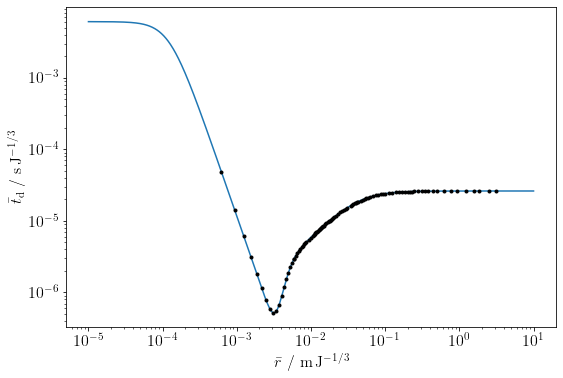

In [186]:
fig, ax = plt.subplots()

xx = np.logspace(-5, 1, 1000)
yy = txisi.tbar(xx)

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$\bar{r}\ /\ \mathrm{m\,J^{-1/3}}$')
ax.set_ylabel(r'$\bar{t}_\mathrm{d}\ /\ \mathrm{s\,J^{-1/3}}$')

ax.plot(xx, yy)
ax.plot(txisi.data.Z, txisi.data.td_bar, '.', color='k')

fig.set_size_inches(8, 5)
fig.subplots_adjust(left=.1, bottom=.1, right=.95, top=.99)

In [187]:
sel1 = selh.loc[selh['pad'] == 2]

sel2 = sel1.loc[sel1.blast == 2]
sel3 = sel2.loc[~np.isnan(sel2.r)]

In [188]:
def dur(r, etot):
    return txisi.tbar(r / etot) * etot

In [189]:
res = curve_fit(dur, sel3.r.values, sel3.t1.values - sel3.ts.values,
                p0=.1 * ETOT)
res

(array([179.67369423]), array([[664.40111473]]))

In [190]:
ETOT

75.85684038249437

In [191]:
def logdur(r, etot):
    return np.log(txisi.tbar(r / etot)) + np.log(etot)

In [192]:
res = curve_fit(logdur, sel3.r.values, np.log(sel3.t1.values - sel3.ts.values))
res

(array([164.91642465]), array([[667.22523196]]))

In [193]:
eatot = res[0][0]
res[0][0] ** 3 / EBLAST

10.275606964978799

For $\bar{r}\gtrsim 0.2\,\mathrm{m\,J^{-1/3}}$ the KG85 model sees a pulse duration that is independent of scaled distance. Mathematically this makes it easy to get and energy

$$
\bar{t}_{\text{d},\infty} = 4.21\cdot10^{-3}\,\mathrm{s\,J^{-1/3}}
= \frac{t_\text{d}}{f_t\,E_a^{1/3}}
$$

$$
\Rightarrow E_a = 
{\Bigl(
    \frac{t_\text{d}}{f_t\,\bar{t}_{\text{d},\infty}}
\Bigr)}^{3}
$$

But the data shows that things are not really constant

In [194]:
sel = summ.query("pad == 2 & blast == 2 & hlabel == 'h'")

In [195]:
sel.Ea

163           NaN
169           NaN
181           NaN
193    32621.2647
205           NaN
217           NaN
241    32621.2647
253    32621.2647
259           NaN
265    32621.2647
277           NaN
289           NaN
301           NaN
Name: Ea, dtype: float64

In [196]:
sel3

pad  ch  blast     pmax   tmax    pmin   tmin   noise      ts    tarr  \
193    2   7      2  244.300  1.393 -75.210  1.397  0.2290  1.3934  1.3934   
241    2  17      2   76.140  1.542 -23.040  1.547  0.2275  1.5421  1.5422   
253    2  19      2   18.840  1.699 -19.570  1.702  0.0091  1.6959  1.6962   
259    2  21      2    9.340  1.860  -4.721  1.868  0.1425  1.8595  1.8596   
265    2  22      2  118.100  1.471 -38.230  1.475  0.0232  1.4707  1.4707   
277    2  25      2    5.526  1.976  -3.890  1.982     NaN  1.9732  1.9735   
289    2  27      2    3.682  2.125  -2.019  2.133  0.2684  2.1229  2.1232   
301    2  29      2    2.256  2.265  -2.003  2.271  0.1218  2.2609  2.2613   

     ...  hlabel     ppf46  alpha  depth    dbar  dredbar    t         c  Ea  \
193  ...       h  207.3664   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN   
241  ...       h   55.9016   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN   
253  ...       h   20.4305   0.05    0.6  0.0079   0.0027  0.5  344.9806 NaN   
259  ...       h    9.6142   0.05    0.6  0.0079   0.0028  0.5  344.9806 NaN   
265  ...       h   93.2065   0.05    0.6  0.0079   0.0021  0.5  344.9806 NaN   
277  ...       h    6.5755   0.05    0.6  0.0079   0.0031  0.5  344.9806 NaN   
289  ...       h    4.5344   0.05    0.6  0.0079   0.0032  0.5  344.9806 NaN   
301  ...       h    2.6144   0.05    0.6  0.0079   0.0033  0.5  344.9806 NaN   

     σEa  
193  NaN  
241  NaN  
253  NaN  
259  NaN  
265  NaN  
277  NaN  
289  NaN  
301  NaN  

[8 rows x 31 columns]

In [197]:
eb22h = sel.Ea[193]
eb22h

32621.264707079907

In [198]:
txisi.tb_large_rb_const * eatot

0.004312057656028115

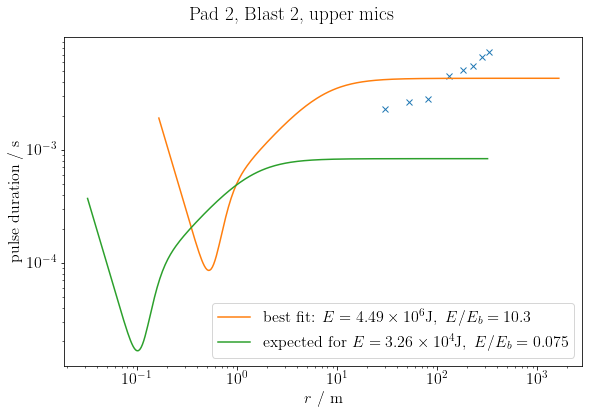

In [199]:
fig, ax = plt.subplots()

ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
ax.set_ylabel(r'$\mathrm{pulse\ duration\ /\ s}$')
ax.plot(sel3.r, sel3.t1 - sel3.ts, 'x')

x = np.logspace(-3, 1, 300)
ax.plot(x * eatot, eatot * txisi.tbar(x),
        label=r'best fit: $E=%.2f\times10^6\mathrm{J},\ E/E_b=%.1f$'
        % (eatot ** 3 / 1e6, eatot ** 3 / EBLAST))
ax.plot(x * eb22h ** ot, eb22h ** ot * txisi.tbar(x),
        label=r'expected for $E=%.2f\times10^4\mathrm{J},\ E/E_b=%.3f$'
        % (eb22h / 1e4, eb22h / EBLAST))

ax.legend(loc='lower right')
fig.set_size_inches(9, 6)
fig.subplots_adjust(left=.15, bottom=.15, right=.95, top=.91)
fig.suptitle('Pad 2, Blast 2, upper mics');

#### Gainville 2010 Example Blast

In [200]:
r_ex = 7.26e3
eblast_ex = 7.6e6 * TNT_EQUIV
etot_ex = eblast_ex ** ot
dur_ex = 0.855

In [201]:
rb_ex = r_ex / etot_ex
rb_ex

0.2291579163185766

In [202]:
rb_ex * ETOT

17.383195480563266

In [203]:
eblast_ex

31798400000000.0

In [204]:
EBLAST

436500.0

In [205]:
eblast_ex / EBLAST

72848568.15578465

In [206]:
30 / ETOT

0.3954818029426277

In [207]:
rb_ex * (.06 * EBLAST) ** ot

6.805290948696997

In [208]:
txisi.tbar(rb_ex) * etot_ex

0.8142723598001497

In [209]:
txisi.tb_large_rb_const * etot_ex

0.8283662655455908

## First Moment $M_{1}$ 

The `m1` column: 

$$
\begin{align}
\tau &= \frac{t-t_s}{t_1-t_s} = \frac{\Delta t}{\Delta t_1}\\
M_1 &= 2\int_0^1\frac{p(\tau)}{p_p}\,d\tau = 2\frac{I_p}{{\Delta t_1}p_p}
= \frac{2}{{\Delta t_1}\,p_p}\int_{t_s}^{t_1}p(t)\,dt
\end{align}
$$

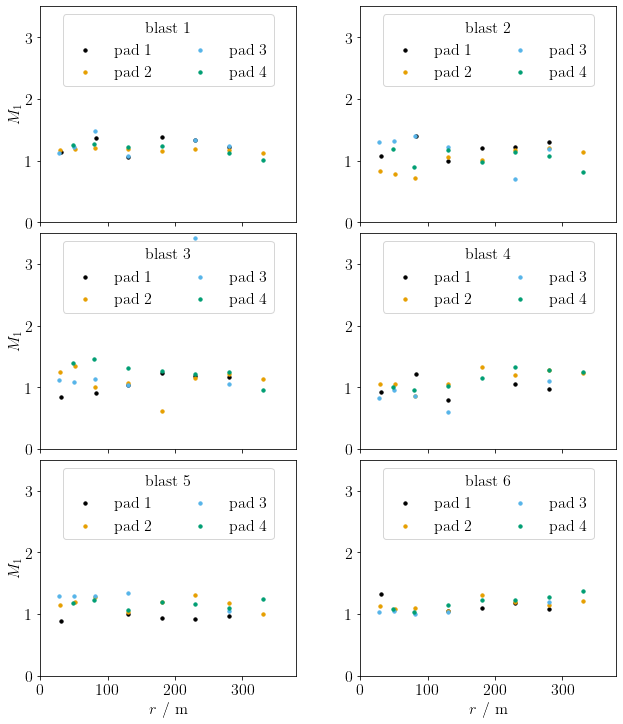

In [210]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True)

for ax, blast in zip(axs.flatten(), [1, 2, 3, 4, 5, 6]):
#     ax.set_xscale('log'); ax.set_yscale('log')
    sel1 = selh.loc[selh.blast == blast]
    for pad in [1, 2, 3, 4]:
        sel2 = sel1.loc[sel1['pad'] == pad]
        ax.scatter(sel2.r, sel2.m1, s=11, c=clrs[pad - 1], label=f'pad {pad}')
        ax.legend(loc='upper center', title=f'blast {blast}', ncol=2)
    ax.set_ylim(0, 3.5)
#     ax.text(.02, .98, f'blast {blast}', ha='left', va='top',
#             transform=ax.transAxes)
for ax in axs[-1, :]:
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
for ax in axs[:, 0]:
    ax.set_ylabel(r'$M_1$')
ax = axs[0, 0]
ax.set_xlim(0, 380)
fig.subplots_adjust(hspace=.05, wspace=.25, top=.97, left=.1)
fig.set_size_inches(10, 11)

## Second Moment $M_2$

The `m2` column:

$$
\begin{align*}
\tau &= \frac{t-t_s}{t_1-t_s} \\
M_2 &= 2 \int_0^\infty\Bigl(\frac{p(\tau)}{p_p}\Bigr)^2d\tau
= \frac{2}{(t_1 - t_s)\,p_p^2}\int_{t_s}^\infty\!\! p^2(t)\,dt
\end{align*}
$$

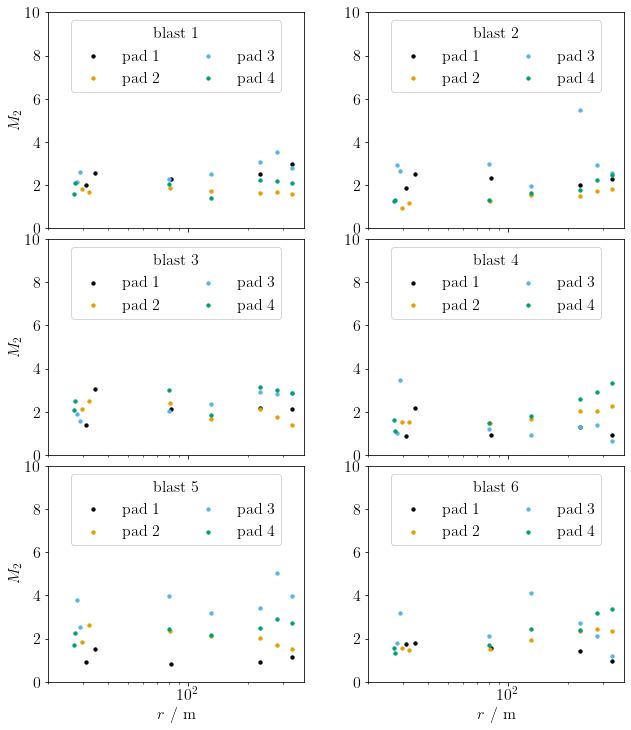

In [211]:
fig, axs = plt.subplots(nrows=3, ncols=2, sharex=True)

xp = np.linspace(20, 380, 300)

for ax, blast in zip(axs.flatten(), [1, 2, 3, 4, 5, 6]):
    ax.set_xscale('log'); ax.set_yscale('linear')
    sel1 = sell.loc[sell.blast == blast]
    for pad in [1, 2, 3, 4]:
        sel2 = sel1.loc[sel1['pad'] == pad]
        ax.scatter(sel2.r, sel2.m2, s=11, c=clrs[pad - 1], label=f'pad {pad}')
    ax.legend(loc='upper center', title=f'blast {blast}', ncol=2)
    ax.set_ylim(0, 10)
for ax in axs[-1, :]:
    ax.set_xlabel(r'$r\ /\ \mathrm{m}$')
for ax in axs[:, 0]:
    ax.set_ylabel(r'$M_2$')
ax = axs[0, 0]
ax.set_xlim(20, 380)
fig.subplots_adjust(hspace=.05, wspace=.25, top=.97, left=.1)
fig.set_size_inches(10, 11)

In [212]:
import asdf
aff = asdf.open(dloc / 'BYU Acoustics/Data/asdf/byu-mics.asdf', mode='rw')
aff.find_references()
aff.info()

root (AsdfObject)
├─asdf_library (Software)
│ ├─author (str): The ASDF Developers
│ ├─homepage (str): http://github.com/asdf-format/asdf
│ ├─name (str): asdf
│ └─version (str): 2.8.1
├─history (dict)
│ └─extensions (list) ...
├─comment (dict)
│ ├─anl/convert-mat-to-asdf.ipynb (dict) ...
│ ├─anl/mics_pulses.ipynb (dict) ...
│ ├─anl/reduced_depths.ipynb (dict) ...
│ ├─data_mamagement/mv-and-clean_byu-mics-summ.ipynb (dict) ...
│ └─mics_c.ipynb (dict) ...
├─pad1 (dict)
│ ├─0 (Reference)
│ ├─1 (Reference)
│ ├─2 (Reference)
│ └─27 not shown
├─pad2 (dict) ...
├─pad3 (dict) ...
├─pad4 (dict) ...
└─summ (dict) ...
Some nodes not shown.


In [213]:
aff.close()